## Conditional Face Generation with Conditional Generative Adversarial Networks (cGANs)

Deep Learning Project

Marcello Sicbaldi

Importing Libraries

In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Concatenate, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout,  GlobalAveragePooling2D, RepeatVector
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model

**Data preprocessing**

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

In [12]:
#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [ ]:
from PIL import Image
from imageio import imread, imwrite

def load_celeba_data(flag='training', side_length=None, num=None):
    dir_path = '/content/data/img_align_celeba/img_align_celeba'
    filelist = [filename for filename in os.listdir(dir_path) if filename.endswith('jpg')]
    assert len(filelist) == 202599
    if flag == 'training':
        start_idx, end_idx = 0, 202599
    #elif flag == 'val':
     #   start_idx, end_idx = 162770, 182637
    #else:
     #     start_idx, end_idx = 182637, 202599

    imgs = []
    
    for i in range(start_idx, end_idx):
        img = np.array(imread(dir_path + os.sep + filelist[i]))
        img = img[45:173,25:153]
        img = np.array(Image.fromarray(img).resize((side_length, side_length),resample=Image.BILINEAR))
        new_side_length = np.shape(img)[1]
        img = np.reshape(img, [1, new_side_length, new_side_length, 3])
        imgs.append(img)
        if num is not None and len(imgs) >= num:
            break
        if len(imgs) % 5000 == 0:
            print('Processing {} images...'.format(len(imgs)))
    imgs = np.concatenate(imgs, 0)

    return imgs.astype(np.uint8)

def preprocess_celeba():
    x_train = load_celeba_data('training', 64)
    np.save('celeba_train.npy', x_train)

preprocess_celeba()

In [13]:
#loading the pre-processed data

x_train = (np.load('/content/drive/My Drive/celeba_faces/celeba_train.npy').astype('float32') - 127.5) / 127.5

In [14]:
#loading the labels

celeba_df = pd.read_csv('/content/data/list_attr_celeba.csv').drop('image_id', axis = 1).replace(-1,0)
y_cols = list(celeba_df.columns)
labels = celeba_df.to_numpy()

In [15]:
#defining the dataset

dataset = [x_train, labels]

In [16]:
batch_size = 64
input_img_size = (64,64,3)                                                        
num_images = 202599 
latent_dim = 100
n_labels = 40
TRAIN = False

Discriminator model

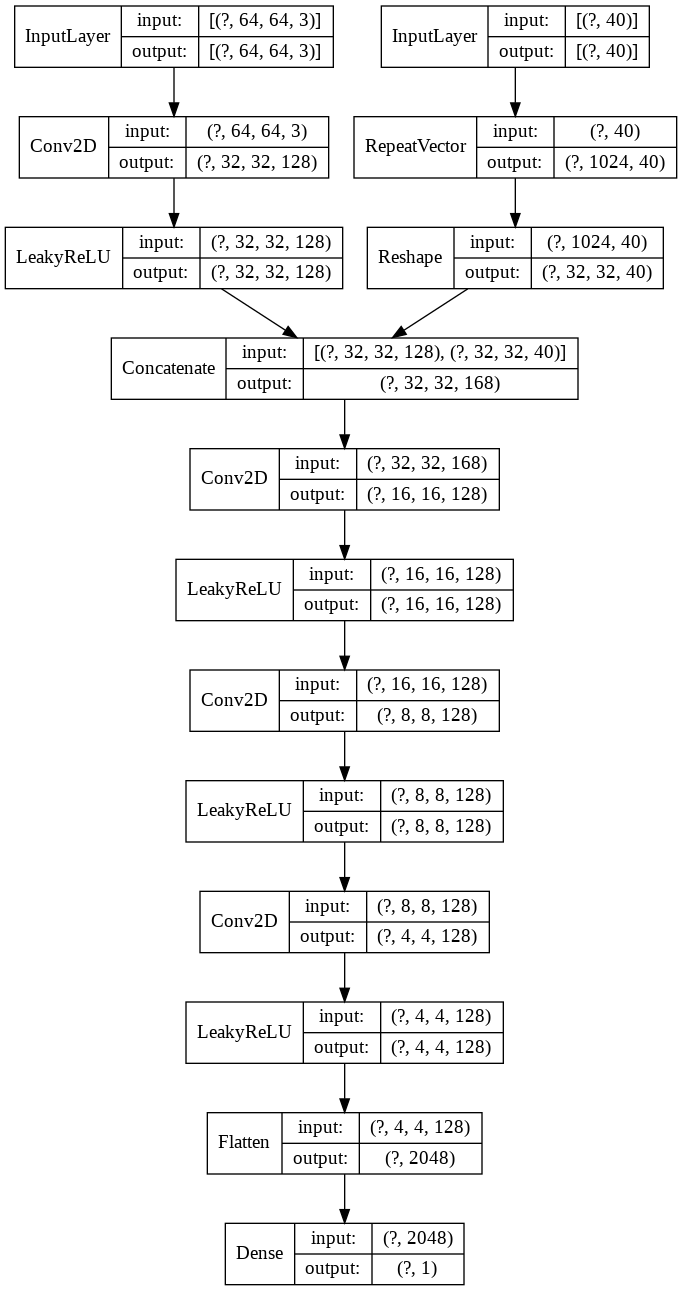

In [17]:
def define_discriminator(in_shape=(64,64,3)):
  
  in_label = Input(shape=(40,))
  in_image = Input(shape=in_shape)
  

  disc = Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')(in_image)
  disc = LeakyReLU(alpha=0.2)(disc)

  r = RepeatVector(32*32)(in_label)
  r = Reshape((32,32,40))(r)

  merge = Concatenate()([disc, r])
  
  disc = Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')(merge)
  disc = LeakyReLU(alpha=0.2)(disc)
  
  disc = Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')(disc)
  disc = LeakyReLU(alpha=0.2)(disc)
  
  disc = Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same')(disc)
  disc = LeakyReLU(alpha=0.2)(disc)
  disc = Flatten()(disc)

  output = Dense(1, activation='sigmoid')(disc)
  model = Model([in_image, in_label], output)

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics = 'accuracy')
  return model

discr = define_discriminator()
plot_model(discr, show_shapes = True, show_layer_names = False)

Generator model

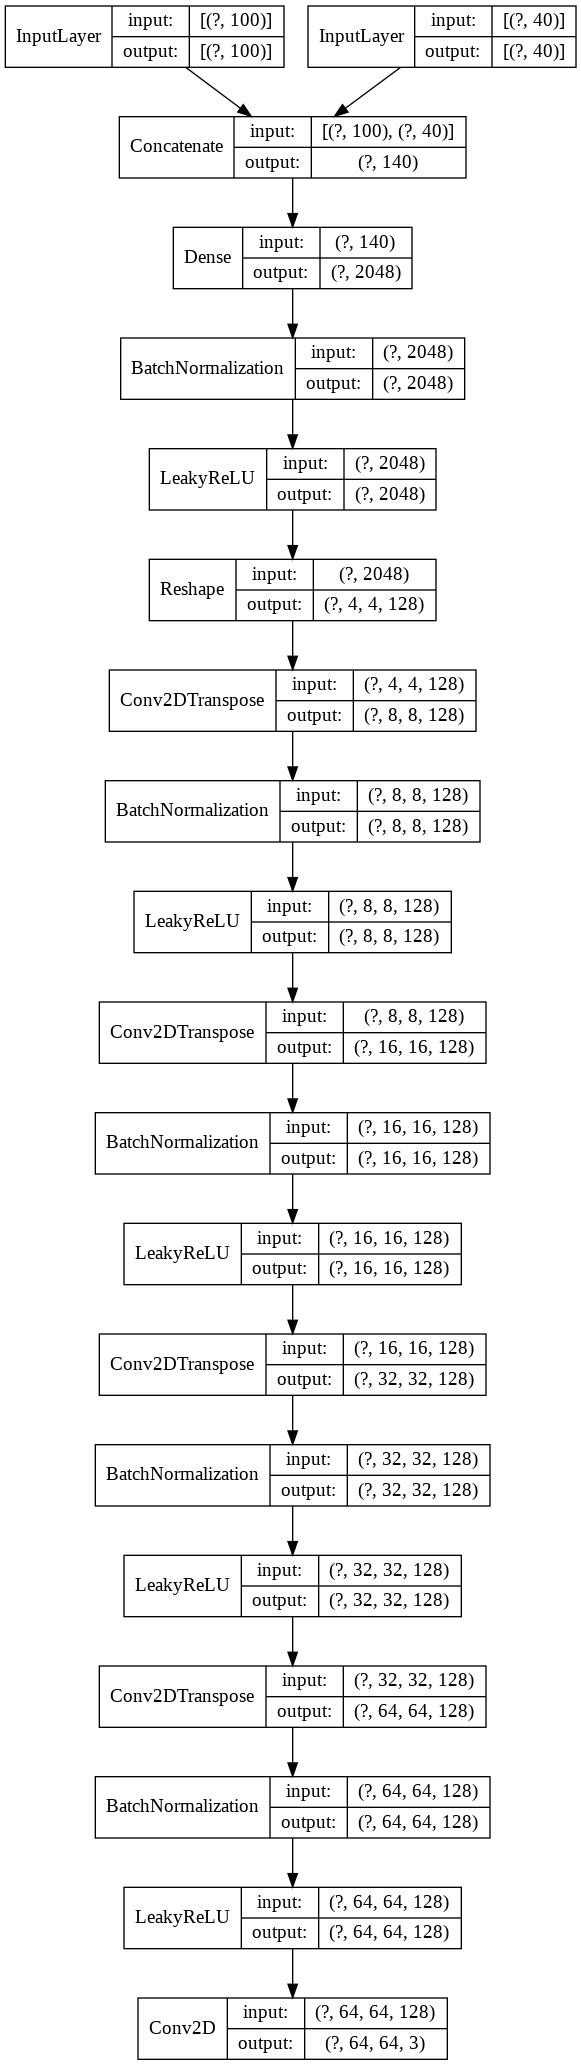

In [18]:
def define_generator(latent_dim, n_classes):

  z = Input(shape=(latent_dim,))
  label = Input(shape = (n_classes,))

  
  merge = Concatenate()([z, label])

  gen = Dense(2048)(merge)
  gen = BatchNormalization()(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Reshape((4, 4, 128))(gen)

  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = BatchNormalization(momentum=0.8)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = BatchNormalization(momentum=0.8)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = BatchNormalization(momentum=0.8)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = BatchNormalization(momentum=0.8)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  output = Conv2D(3, kernel_size=(5,5), activation='tanh', padding='same')(gen)

  model = Model([z, label], output)

  return model
generator = define_generator(latent_dim, n_labels)
plot_model(generator, show_shapes = True, show_layer_names = False)

Gan model

In [19]:
def define_gan(generator, discriminator):
	# make the discriminator not trainable
	discriminator.trainable = False
	# get noise and label inputs from generator model
	z, label = generator.input
	# get image output from the generator model
	gen_output = generator.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = discriminator([gen_output, label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([z, label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

gan = define_gan(generator, discr)

In [20]:
#This function generates n true samples [image, label], associated with the value 1

def true_images(dataset=dataset, n = 100):
  images, labels = dataset
  ix = np.random.randint(0, images.shape[0], n)
  X, labels = images[ix], labels[ix]
  y = np.ones((n, 1))
  return [X, labels], y

In [21]:
#this function generates the latent vector in input to the generator along with randomly selected labels

def input_gen(latent_dim = latent_dim, n = 100, n_classes=40):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n, latent_dim)
	# generate labels
	labels = celeba_df[y_cols].sample(n).values
	return [z_input, labels]

In [22]:
# this function generates n fake samples [image, label], associated with the value 0

def fake_images(generator, latent_dim, n):
  # generate points in latent space
  z_input, labels_input = input_gen(latent_dim, n)
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = np.zeros((n, 1))
  return [images, labels_input], y

In [23]:
# This function shows 25 images from a batch 

def show_plot(image_batch):
  # Define the onscreen size of the image
  plt.figure(figsize=(10, 10))

  # For each of 25 images from the batch
  for n in range(25):
    # Plot the image with pixel values scaled from [-1,1] to [0,255]
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(((image_batch[n] * 127.5) + 127.5) / 255)
    plt.axis('off')
  
  # Plot the images
  plt.show()

In [24]:
#this function plots the images and saves the models 

def summarize_performance(step, g_model, latent_dim, n=128):
  # prepare fake examples
  [X, _], _ = fake_images(g_model, latent_dim, n)
  # This function shows 25 images from a batch of images
  show_plot(X)
  # save the generator model
  filename = '/content/drive/My Drive/conditional_gan/c_gan_%04d.h5' % (step+1)
  g_model.save(filename)
  print('model saved: %s' % (filename))

Training

In [25]:
def train(generator, discriminator, gan, dataset, latent_dim = latent_dim, n_epochs=100, batch_size=batch_size):
  batch_per_epo = int(dataset[0].shape[0] / batch_size)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(batch_per_epo):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = true_images(dataset, batch_size)
      # update discriminator model weights
      d_loss1, _ = discriminator.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = fake_images(generator, latent_dim, batch_size)
      # update discriminator model weights
      d_loss2, _ = discriminator.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = input_gen(latent_dim, batch_size)
      # create inverted labels for the fake samples
      y_gan = np.ones((batch_size, 1))
      # update the generator 
      g_loss = gan.train_on_batch([z_input, labels_input], y_gan)
    # print loss and summarize performance 
    if (i+1) % 1 == 0:
      print('%d epochs, d1_loss=%.3f, d2_loss=%.3f g_loss=%.3f' %
       (i+1, d_loss1, d_loss2, g_loss))
      summarize_performance(i, generator, latent_dim)

In [26]:
if TRAIN == True:
  train(generator, discr, gan, dataset)

Loading pre-trained model

In [27]:
if TRAIN == False:
  generator = load_model('/content/drive/My Drive/conditional_gan/best_conditional_generator.h5')

Images with random attributes

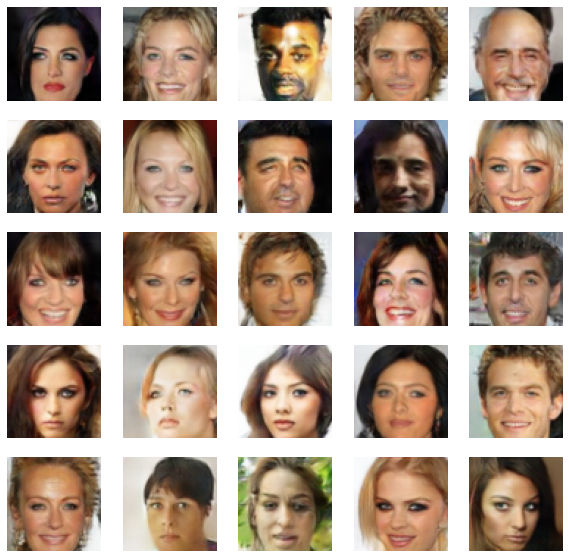

In [ ]:
sample_comb = input_gen()
generated_sample = generator.predict(sample_comb)
show_plot(generated_sample)

Conditional generation

In [ ]:
attributes = np.full(shape=(64, n_labels), fill_value=0, dtype=np.int32)

In [37]:
#@title Attributes
Male = False #@param {type:"boolean"}
attributes[:,20] = int(Male)
Young = True #@param {type:"boolean"}
attributes[:,39] = int(Young)
Bald = False #@param {type:"boolean"}
attributes[:,4] = int(Bald)

Receding_Hairline = False #@param {type:"boolean"}
attributes[:,28] = int(Receding_Hairline)

Sideburns =  False #@param {type:"boolean"}
attributes[:,30] = int(Sideburns)

Bangs = False #@param {type:"boolean"}
attributes[:,5] = int(Bangs)

Black_Hair = False #@param {type:"boolean"}
attributes[:,8] = int(Black_Hair)

Blonde_Hair = True #@param {type:"boolean"}
attributes[:,9] = int(Blonde_Hair)

Brown_Hair = False #@param {type:"boolean"}
attributes[:,11] = int(Brown_Hair)

Gray_Hair = False #@param {type:"boolean"}
attributes[:,17] = int(Gray_Hair)

Straight_Hair = False #@param {type:"boolean"}
attributes[:,32] = int(Straight_Hair)

Wavy_Hair = False #@param {type:"boolean"}
attributes[:,33] = int(Wavy_Hair)

Narrow_Eyes = False #@param {type:"boolean"}
attributes[:,23] = int(Narrow_Eyes)

Arched_Eyebrows = False #@param {type:"boolean"}
attributes[:,1] = int(Arched_Eyebrows)

Bushy_Eyebrows = False #@param {type:"boolean"}
attributes[:,12] = int(Bushy_Eyebrows)

Eyeglasses = False #@param {type:"boolean"}
attributes[:,15] = int(Eyeglasses)

Bags_Under_Eyes = False #@param {type:"boolean"}
attributes[:,3] = int(Bags_Under_Eyes)

Chubby = False #@param {type:"boolean"}
attributes[:,13] = int(Chubby)

Double_Chin = False #@param {type:"boolean"}
attributes[:,14] = int(Double_Chin)

High_Cheekbones = False #@param {type:"boolean"}
attributes[:,19] = int(High_Cheekbones)

Oval_Face = False #@param {type:"boolean"}
attributes[:,25] = int(Oval_Face)

Pale_Skin = False #@param {type:"boolean"}
attributes[:,26] = int(Pale_Skin)

Rosy_Cheeks = False #@param {type:"boolean"}
attributes[:,29] = int(Rosy_Cheeks)

Attractive = True #@param {type:"boolean"}
attributes[:,2] = int(Attractive)

Big_Nose = False #@param {type:"boolean"}
attributes[:,7] = int(Big_Nose)

Pointy_Nose = False #@param {type:"boolean"}
attributes[:,27] = int(Pointy_Nose)

Big_Lips = False #@param {type:"boolean"}
attributes[:,6] = int(Big_Lips)

Mouth_Slightly_Open = False #@param {type:"boolean"}
attributes[:,21] = int(Mouth_Slightly_Open)

Smiling = True #@param {type:"boolean"}
attributes[:,31] = int(Smiling)

Goatee = False #@param {type:"boolean"}
attributes[:,16] = int(Goatee)

Mustache = False #@param {type:"boolean"}
attributes[:,22] = int(Mustache)

No_Beard = False #@param {type:"boolean"}
attributes[:,24] = int(No_Beard)

Heavy_Makeup = False #@param {type:"boolean"}
attributes[:,18] = int(Heavy_Makeup)

Wearing_Lipstick = False #@param {type:"boolean"}
attributes[:,36] = int(Wearing_Lipstick)

Wearing_Earrings = False #@param {type:"boolean"}
attributes[:,34] = int(Wearing_Earrings)

Wearing_Hat = False #@param {type:"boolean"}
attributes[:,35] = int(Wearing_Hat)

Wearing_Necklace = False #@param {type:"boolean"}
attributes[:,37] = int(Wearing_Necklace)

Wearing_Necktie = False #@param {type:"boolean"}
attributes[:,38] = int(Wearing_Necktie)

Five_o_Clock_Shadow = False #@param {type:"boolean"}
attributes[:,0] = int(Five_o_Clock_Shadow)

Blurry = False #@param {type:"boolean"}
attributes[:,10] = int(Blurry)

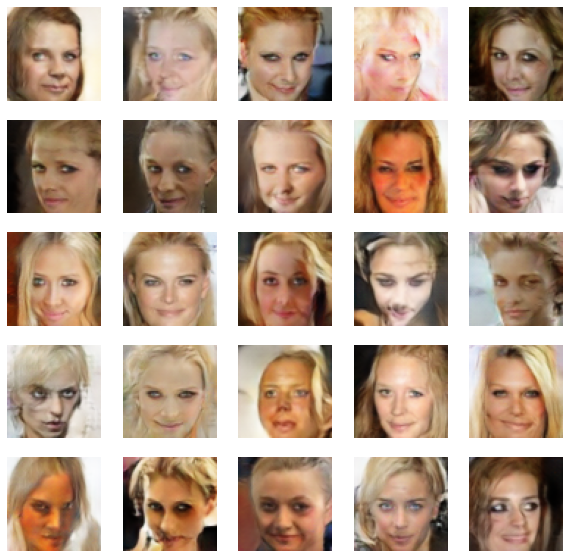

In [42]:
sample_noise = input_gen(n = 64)[0]
sample_combination = [sample_noise, attributes]
generated_sample = generator.predict(sample_combination)
show_plot(generated_sample)

Calculating FID score

In [ ]:
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from skimage.transform import resize
from numpy.random import shuffle
from scipy.linalg import sqrtm
import cv2

def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		new_image = resize(image, new_shape, 1) #bilinear interpolation
		# store
		images_list.append(new_image)
	return np.asarray(images_list)
 
# precompute activations for every batch and concatenate them
def compute_activations_real(img, model, batch_size):
  act = np.zeros([10000, 2048], dtype = np.float32) 
  for i in range(10000//batch_size):
    images = img[i * batch_size:(i + 1) * batch_size] 
    batch = scale_images(images.astype('float32'), (299,299,3))
    act[i * batch_size : (i + 1) * batch_size] = model.predict(batch)
  return act

def compute_activations_generated(generator, model, batch_size):
  act = np.zeros([10000, 2048], dtype = np.float32) 
  for i in range(10000//batch_size):
    images = generator.predict(input_gen(latent_dim, batch_size))
    batch = scale_images(images.astype('float32'), (299,299,3))
    act[i * batch_size : (i + 1) * batch_size] = model.predict(batch)
  return act

def calculate_fid(generator):
	# calculate activations
  act_real = compute_activations_real(x_train[110000:], inc_model, 64)
  act_gen = compute_activations_generated(generator, inc_model, 64)
	# calculate mean and covariance statistics
  mu1, sigma1 = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
  mu2, sigma2 = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
	# calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
	# calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

inc_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
calculate_fid(generator)

11.738633449163048

The following function computes the mean squared error between every single image of the dataset and one generated image. Then returns the most similar image of the dataset to the generated one. 

In [43]:
def diff(image):
  x = np.zeros(len(x_train))
  for im in range(len(x_train)):
    x[im] = np.mean(np.square(x_train[im] - image))
  best = np.argmin(x)
  return x_train[best]

In [44]:
best = diff(generated_sample[11])

Plotting the generated image and the most similar image to it in the dataset. This is done in order to have visual confirmation that the generator has learned to generate never seen before faces

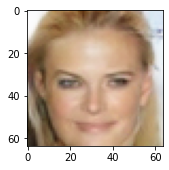

In [50]:
plt.figure(figsize = (2.5,2.5))
plt.imshow(((generated_sample[11] * 127.5) + 127.5) / 255)

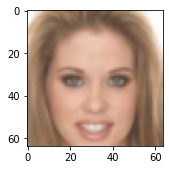

In [51]:
plt.figure(figsize = (2.5,2.5))
plt.imshow(((best* 127.5) + 127.5) / 255)